Importing relevant libraries


In [2]:
import cv2
import torch
import urllib.request
import numpy as np
import matplotlib.pyplot as plt

filename ="dog.jpg"

c:\Users\SalmaneElFtouh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
c:\Users\SalmaneElFtouh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
c:\Users\SalmaneElFtouh\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


Load a model (see [https://github.com/intel-isl/MiDaS/#Accuracy](https://github.com/intel-isl/MiDaS/#Accuracy) for an overview)

In [3]:
#model_type = "DPT_Large"     # MiDaS v3 - Large     (highest accuracy, slowest inference speed)
#model_type = "DPT_Hybrid"   # MiDaS v3 - Hybrid    (medium accuracy, medium inference speed)
model_type = "MiDaS_small"  # MiDaS v2.1 - Small   (lowest accuracy, highest inference speed)

midas = torch.hub.load("intel-isl/MiDaS", model_type)

Using cache found in C:\Users\SalmaneElFtouh/.cache\torch\hub\intel-isl_MiDaS_master


Loading weights:  None


Using cache found in C:\Users\SalmaneElFtouh/.cache\torch\hub\rwightman_gen-efficientnet-pytorch_master


Move model to GPU if available

In [4]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
midas.to(device)
midas.eval()
print("Done")

Done


Load transforms to resize and normalize the image for large or small model

In [5]:
midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")

if model_type == "DPT_Large" or model_type == "DPT_Hybrid":
    transform = midas_transforms.dpt_transform
else:
    transform = midas_transforms.small_transform

Using cache found in C:\Users\SalmaneElFtouh/.cache\torch\hub\intel-isl_MiDaS_master


Load image and apply transforms

In [6]:
img = cv2.imread(filename)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

input_batch = transform(img).to(device)

Predict and resize to original resolution

In [7]:
with torch.no_grad():
    prediction = midas(input_batch)

    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1),
        size=img.shape[:2],
        mode="bicubic",
        align_corners=False,
    ).squeeze()

output = prediction.cpu().numpy()

Show result

904


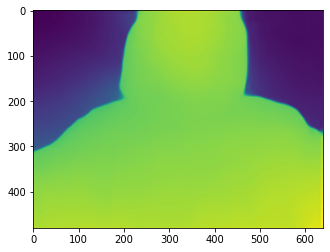

In [15]:
plt.imshow(output)
print(np.max(output))
# plt.show()

Using depth estimation on webcam

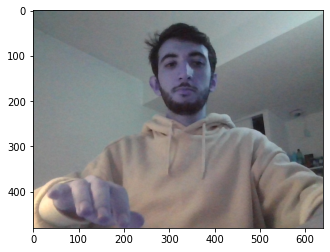

In [24]:

cap = cv2.VideoCapture(0)
while cap.isOpened():
    ret, frame = cap.read()

    img = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    input_batch = transform(img).to(device)

    with torch.no_grad():
        prediction = midas(input_batch)

        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    output = (prediction.cpu().numpy())
    output=(output*255/np.max(output)).astype(np.uint8)
    #print(output[:50,:50],np.min(output),np.max(output))
    #break
    #img_to_show = cv2.cvtColor(output, cv2.COLOR_GRAY2BGR)    
    #print(frame.shape,output.shape,img_to_show.shape)
    
    cv2.imshow('webcam', output)
    cv2.imshow('frame', frame)
    key = cv2.waitKey(1) & 0xff

    if key == ord('q'):
        break

cv2.destroyAllWindows()
cap.release()
plt.imshow(output)